# Back-Testing for Algorithmic Trading Strategies

<b>How to choose a strategy? It would be a good start to test alternative strategies retrospectively, knowing which of these strategies worked best in the past and produced more accurate signals. This is called Back-Test.<b>

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yahoofinancials as yf
from yahoo_fin.stock_info import *
import requests_html
import requests
import ftplib
import ta as ta


<b>Let's get the historical time series data of the stock by specifying the start and end dates<b>

In [37]:
history = yf.YahooFinancials('TSLA').get_historical_price_data('2021-01-01', '2021-12-31', 'daily')
df = pd.DataFrame(history['TSLA']['prices'])
df.head()

,date,high,low,open,close,volume,adjclose,formatted_date
0,1609770600,248.163330,239.063339,239.820007,243.256668,145914600,243.256668,2021-01-04
1,1609857000,246.946671,239.733337,241.220001,245.036667,96735600,245.036667,2021-01-05
2,1609943400,258.000000,249.699997,252.830002,251.993332,134100000,251.993332,2021-01-06
3,1610029800,272.329987,258.399994,259.209991,272.013336,154496700,272.013336,2021-01-07
4,1610116200,294.829987,279.463318,285.333344,293.339996,225166500,293.339996,2021-01-08


In [38]:
df.drop('date', axis=1, inplace=True)

In [39]:
df.index = pd.to_datetime(df['formatted_date'])
df.drop('formatted_date', axis=1, inplace=True)

<b>Let's change the name of the adjclose variable to 'Price'.<b>

In [40]:
df.rename(columns={'adjclose': 'price'}, inplace=True)

<b>Let's change the price change to 'return' (daily return) and assign the percentage change in the price to 'return_pct'.

In [41]:
df["return"] = df["price"].diff()
df["return_pct"] = df["price"].pct_change()

<b>Time Series Graph of Price and Return

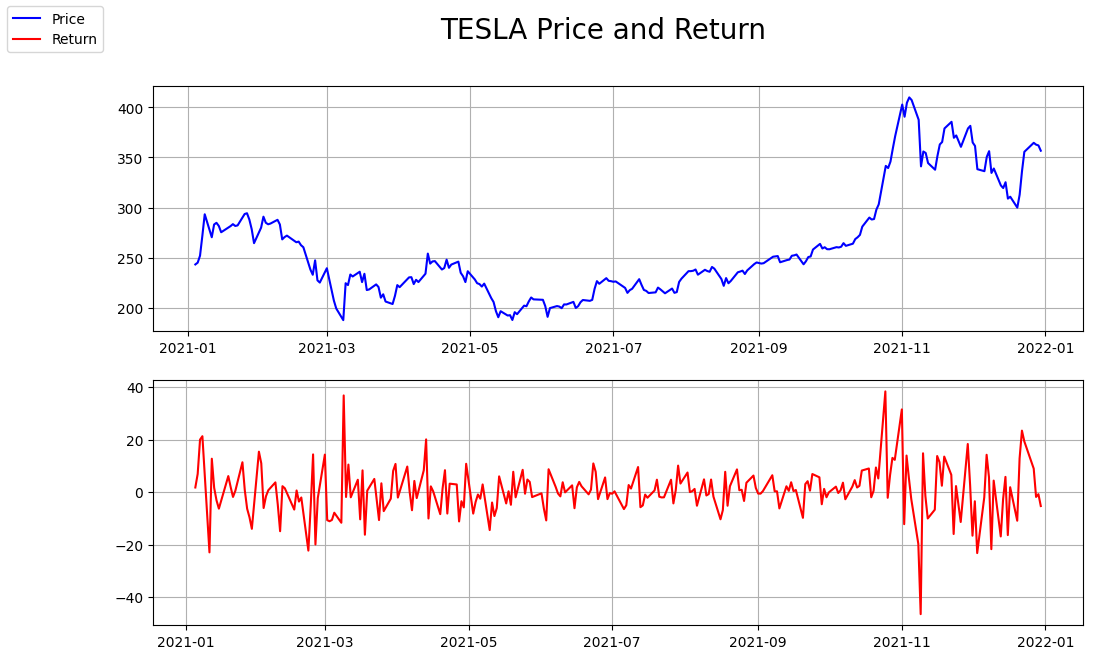

In [42]:
f, axarr = plt.subplots(2,sharex=False,figsize=(12,7))
f.suptitle('TESLA Price and Return', fontsize=20)
axarr[0].plot(df['price'], color='blue')
axarr[0].grid(True)
axarr[1].plot(df['return'], color='red')
axarr[1].grid(True)
f.legend(['Price', 'Return'], loc='upper left')
plt.show()

# Three Alternative Strategies

- <b>1) Price > EMA10 : If the price goes above the 10-day exponential moving average, it is considered a buy signal.<b>

- <b>2) EMA10 > EMA30 : When the 10-day exponential moving average rises above the 30-day exponential moving average, it can be considered as a buy signal.<b>

- <b>3) MACD > MACDS : The MACD indicator is the difference between the exponential values of the 26 and 12-day moving average. The 9-day exponential moving average of the MACD is called the MACD Signal (MACDS). If the MACD goes above the MACDS, it is considered a buy signal.<b>

<b>1) Price > EMA10  (s1)

In [43]:
df["EMA10"] = ta.trend.ema_indicator(df["price"],10,fillna=True)

<b>Let's create Buy-Sell Signals

In [44]:
df["buy_s1"] = np.where(df["price"] > df["EMA10"], 1, 0)
df["sell_s1"] = np.where(df["price"] < df["EMA10"], 1, 0)
df["buy_s1_ind"] = np.where((df["buy_s1"] > df["buy_s1"].shift(1)),1, 0)
df["sell_s1_ind"] = np.where((df["sell_s1"] > df["sell_s1"].shift(1)),1, 0)

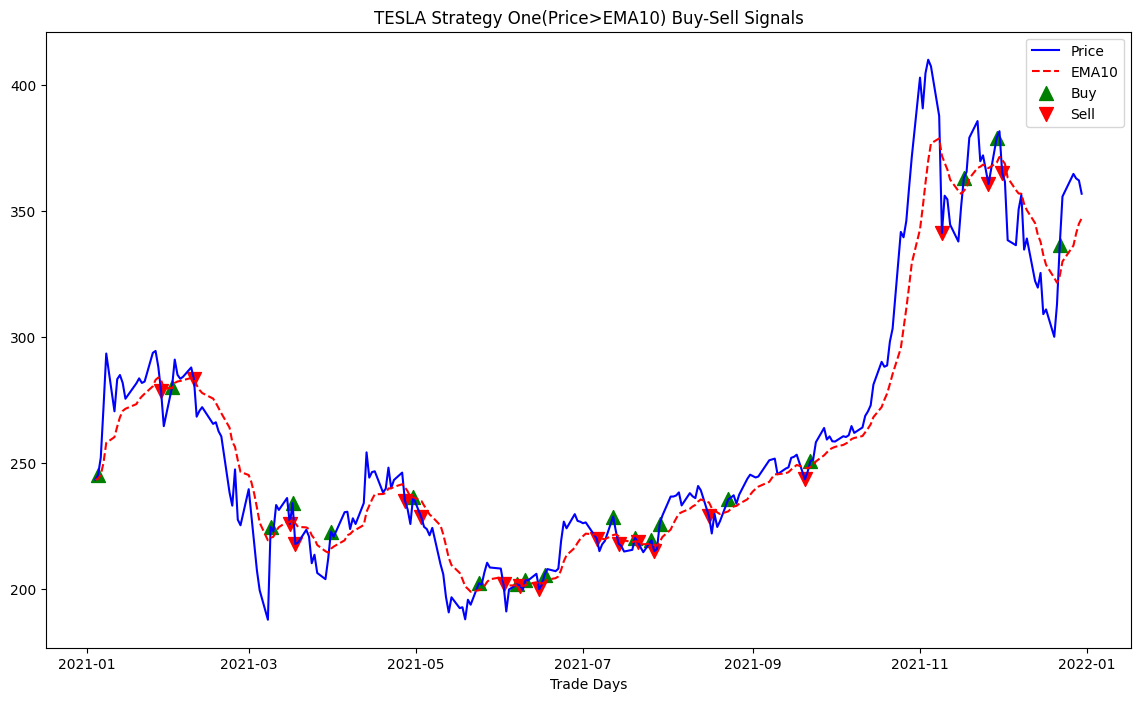

In [45]:
df["date"] = df.index

fig1 = plt.figure(figsize=(14,8))
plt.plot(df["price"],label="Price",color='blue')
plt.plot(df["EMA10"],label="EMA10",color='red',linestyle='--')
plt.scatter(df.loc[df["buy_s1_ind"] == 1].index, 
            df["price"][df["buy_s1_ind"] == 1], color='green', marker='^', s=100, label="Buy")

plt.scatter(df.loc[df["sell_s1_ind"] == 1].index,
            df["price"][df["sell_s1_ind"] == 1], color='red', marker='v', s=100, label="Sell")

plt.xlabel('Trade Days')
plt.legend(loc='best')
plt.title('TESLA Strategy One(Price>EMA10) Buy-Sell Signals')
plt.show()

<b>According to the Strategy One, the profit of the trader who trades with $1000 in the relevant period:

Assuming we allocate 5% of the return as transaction costs, then we will consider 95% of the percentage return.<b>

In [46]:
df["value_s1"] = 1000*(1+(np.where(df["buy_s1"]==1,
                                0.95*df["return_pct"],0)).cumsum())

# Back-Test Report (s1)

In [47]:
print("************* Descriptive Statistics *************")
print("Period",len(df),"days")
print("Highest Daily Loss ",100*round(df["return_pct"].min(),2),"%")
print("Highest Daily Return ",100*round(df["return_pct"].max(),2),"%")
print("Standard Deviation of Return ",100*round(df["return_pct"].std(),2),"%")
print("Total Potential Return ",100*(round(sum(np.where((df["return_pct"]>0),df["return_pct"],0)),2)),"%")
print("Total Potential Loss ",100*(round(sum(np.where((df["return_pct"]<0),df["return_pct"],0)),2)),"%")
print("Net Return ",100*df["return_pct"].sum().round(2),"%")

print("************* MODEL PERFORMANCE *************")

print("Return Captured by the Model ",100*sum(np.where((df["buy_s1"]==1),df["return_pct"],0)).round(2),"%")
print("Loss Maintained by the Model ",100*sum(np.where((df["sell_s1"]==1),df["return_pct"],0)).round(2),"%")
print("**************************************************")


************* Descriptive Statistics *************
Period 251 days
Highest Daily Loss  -12.0 %
Highest Daily Return  20.0 %
Standard Deviation of Return  3.0 %
Total Potential Return  336.0 %
Total Potential Loss  -283.0 %
Net Return  53.0 %
************* MODEL PERFORMANCE *************
Return Captured by the Model  200.0 %
Loss Maintained by the Model  -147.0 %
**************************************************


In [48]:
print("************* REPORT *************")
print("The end-of-period price of the stock, which was $",df["price"][0].round(2),
    "at the beginning of the period, became $",df["price"][-1].round(2),"with %",
    (100*(df["price"][-1]-df["price"][0])/df["price"][0]).round(2),"change","The model captured %",
    100*(sum(np.where((df["buy_s1"]==1),df["return_pct"],0))/sum(np.where((df["return_pct"]>0),
                                                                    df["return_pct"],0))).round(2),
    "of the total positive return.The investment of $1000 at the beginning of the period became $",
    df["value_s1"][-1].round(2),
    "on the first",len(df),"days.")

************* REPORT *************
The end-of-period price of the stock, which was $ 243.26 at the beginning of the period, became $ 356.78 with % 46.67 change The model captured % 59.0 of the total positive return.The investment of $1000 at the beginning of the period became $ 2896.76 on the first 251 days.


<b>The sum of the percentage gains on the days when the stock increased was 336%, and the sum of the percentage loss on the days when the stock decreased was 283%. For the price > EMA10 strategy, it correctly saw 59% of the potential positive gain. On the days when the price correctly indicated that the price would increase and gave a buy signal, the return was 200%. However, someone who bought this stock at the beginning of the period and sold it at the end of the period made a profit of 46%, but according to the signals, the one who traded made a profit of 189.67% for $ 1000.<b>

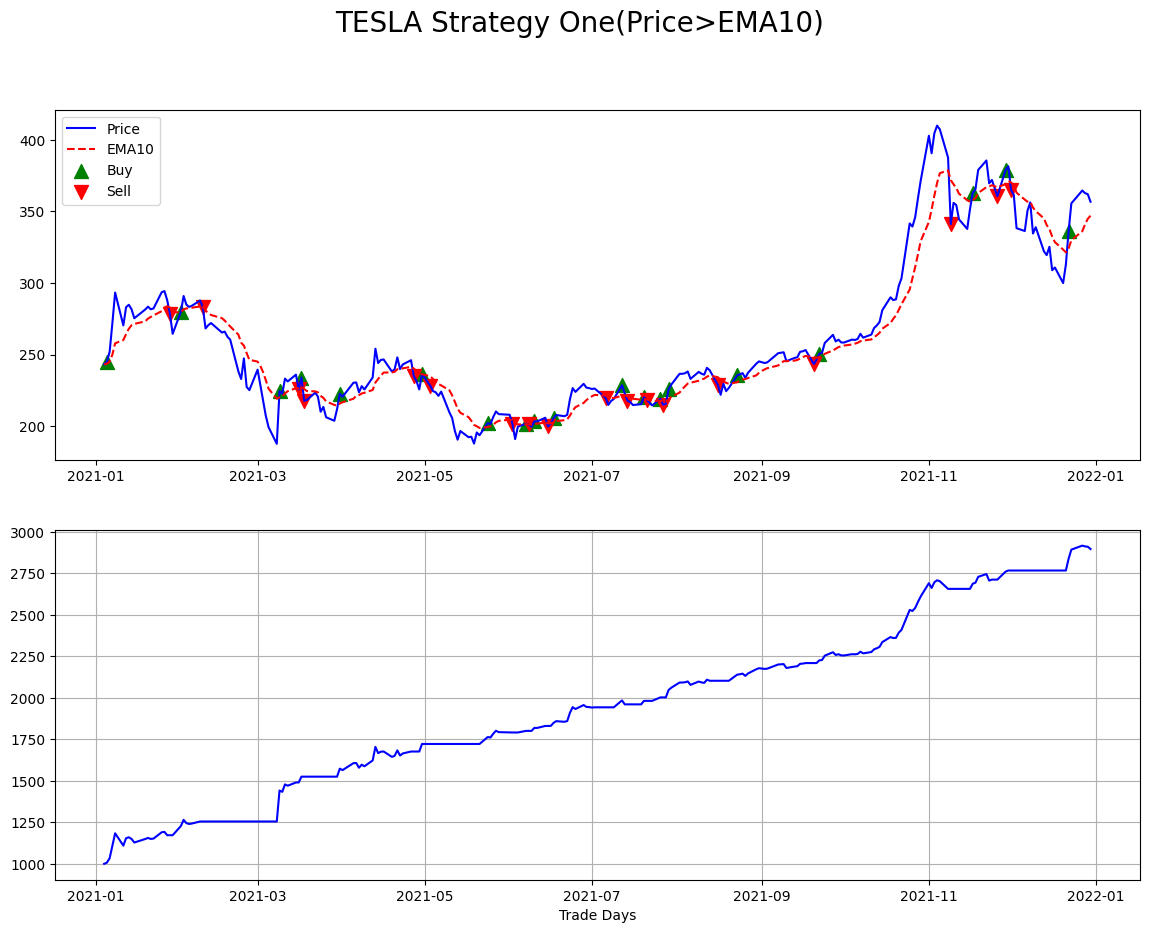

In [49]:
df["date"] = df.index
f,axarr = plt.subplots(2,sharex=False,figsize=(14,10))
f.suptitle('TESLA Strategy One(Price>EMA10)', fontsize=20)
axarr[0].plot(df["price"],label="Price",color='blue')
axarr[0].plot(df["EMA10"],label="EMA10",color='red',linestyle='--')
axarr[0].scatter(df.loc[df["buy_s1_ind"] == 1].index,
                df.loc[df["buy_s1_ind"] == 1,"price"].values, color='green', marker='^', s=100, label="Buy")
axarr[0].scatter(df.loc[df["sell_s1_ind"] == 1].index,
                df.loc[df["sell_s1_ind"] == 1,"price"].values, color='red', marker='v', s=100, label="Sell")

axarr[0].legend(loc='best')
axarr[1].plot(df["value_s1"],label="Algorithmic Gain",color='blue')
plt.grid(True)
plt.xlabel('Trade Days')
plt.show()

<b>The algorithmic payoff exceeds the potential payoff. Why? Because the investor often earned additional income by selling high and buying low. The cumulative sum of these is greater than the potential gain. Let's Back-Test the same implementation in the other two strategies.<b>

<b>2) EMA10 > EMA30 (s2)

In [50]:
df["EMA30"] = ta.trend.ema_indicator(df["price"],30,fillna=True)

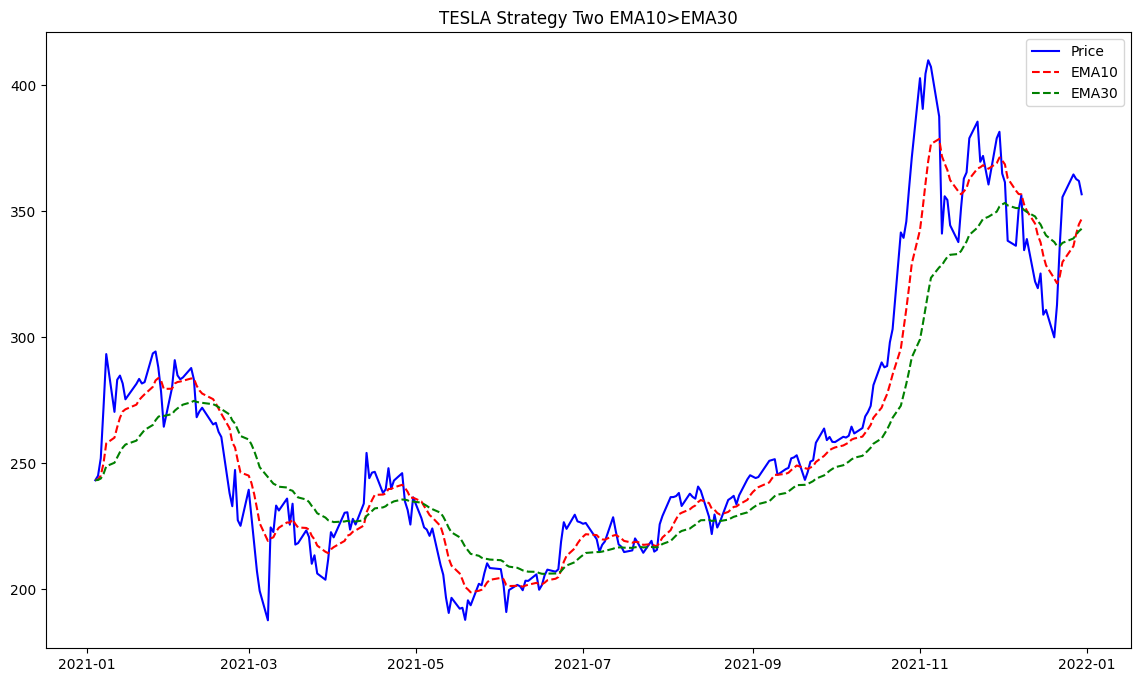

In [51]:
fig1 = plt.figure(figsize=(14,8))
plt.plot(df["price"],label="Price",color='blue')
plt.plot(df["EMA10"],label="EMA10",color='red',linestyle='--')
plt.plot(df["EMA30"],label="EMA30",color='green',linestyle='--')
plt.legend(loc='best')
plt.title('TESLA Strategy Two EMA10>EMA30')
plt.show()

In [52]:
df["buy_s2"] = np.where((df["EMA10"] > df["EMA30"]), 1, 0)
df["sell_s2"] = np.where((df["EMA10"] < df["EMA30"]), 1, 0)
df["buy_s2_ind"] = np.where((df["buy_s2"] > df["buy_s2"].shift(1)),1, 0)
df["sell_s2_ind"] = np.where((df["sell_s2"] > df["sell_s2"].shift(1)),1, 0)

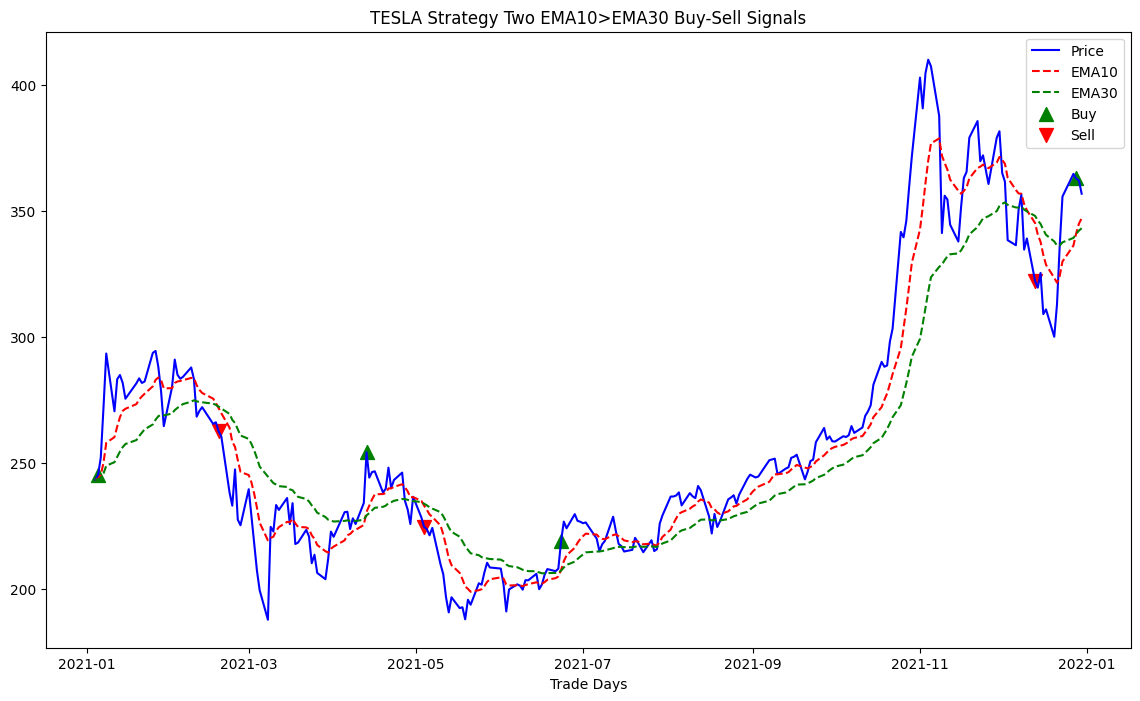

In [53]:
df["date"] = df.index

fig1 = plt.figure(figsize=(14,8))
plt.plot(df["price"],label="Price",color='blue')
plt.plot(df["EMA10"],label="EMA10",color='red',linestyle='--')
plt.plot(df["EMA30"],label="EMA30",color='green',linestyle='--')
plt.scatter(df.loc[df["buy_s2_ind"] == 1].index,
            df["price"][df["buy_s2_ind"] == 1], color='green', marker='^', s=100, label="Buy")
plt.scatter(df.loc[df["sell_s2_ind"] == 1].index,
            df["price"][df["sell_s2_ind"] == 1], color='red', marker='v', s=100, label="Sell")

plt.xlabel('Trade Days')
plt.legend(loc='best')
plt.title('TESLA Strategy Two EMA10>EMA30 Buy-Sell Signals')
plt.show()

<b>Trading Gain according to Strategy Two

In [54]:
df["value_s2"] = 1000*(1+(np.where(df["buy_s2"]==1,
                                0.95*df["return_pct"],0)).cumsum())

# Back-Test Report (s2)

In [55]:
print("************* Descriptive Statistics *************")
print("Period",len(df),"days")
print("Highest Daily Loss ",100*round(df["return_pct"].min(),2),"%")
print("Highest Daily Return ",100*round(df["return_pct"].max(),2),"%")
print("Standard Deviation of Return ",100*round(df["return_pct"].std(),2),"%")
print("Total Potential Return ",100*(round(sum(np.where((df["return_pct"]>0),df["return_pct"],0)),2)),"%")
print("Total Potential Loss ",100*(round(sum(np.where((df["return_pct"]<0),df["return_pct"],0)),2)),"%")
print("Net Return ",100*df["return_pct"].sum().round(2),"%")

print("************* MODEL PERFORMANCE *************")

print("Return Captured by the Model ",100*sum(np.where((df["buy_s2"]==1),df["return_pct"],0)).round(2),"%")
print("Loss Maintained by the Model ",100*sum(np.where((df["sell_s2"]==1),df["return_pct"],0)).round(2),"%")
print("**************************************************")


************* Descriptive Statistics *************
Period 251 days
Highest Daily Loss  -12.0 %
Highest Daily Return  20.0 %
Standard Deviation of Return  3.0 %
Total Potential Return  336.0 %
Total Potential Loss  -283.0 %
Net Return  53.0 %
************* MODEL PERFORMANCE *************
Return Captured by the Model  61.0 %
Loss Maintained by the Model  -8.0 %
**************************************************


In [56]:
print("************* REPORT *************")
print("The end-of-period price of the stock, which was $",df["price"][0].round(2),
    "at the beginning of the period, became $",df["price"][-1].round(2),"with %",
    (100*(df["price"][-1]-df["price"][0])/df["price"][0]).round(2),"change","The model captured %",
    100*(sum(np.where((df["buy_s2"]==1),df["return_pct"],0))/sum(np.where((df["return_pct"]>0),
                                                                    df["return_pct"],0))).round(2),
    "of the total positive return.The investment of $1000 at the beginning of the period became $",
    df["value_s2"][-1].round(2),
    "on the first",len(df),"days.")

************* REPORT *************
The end-of-period price of the stock, which was $ 243.26 at the beginning of the period, became $ 356.78 with % 46.67 change The model captured % 18.0 of the total positive return.The investment of $1000 at the beginning of the period became $ 1581.24 on the first 251 days.


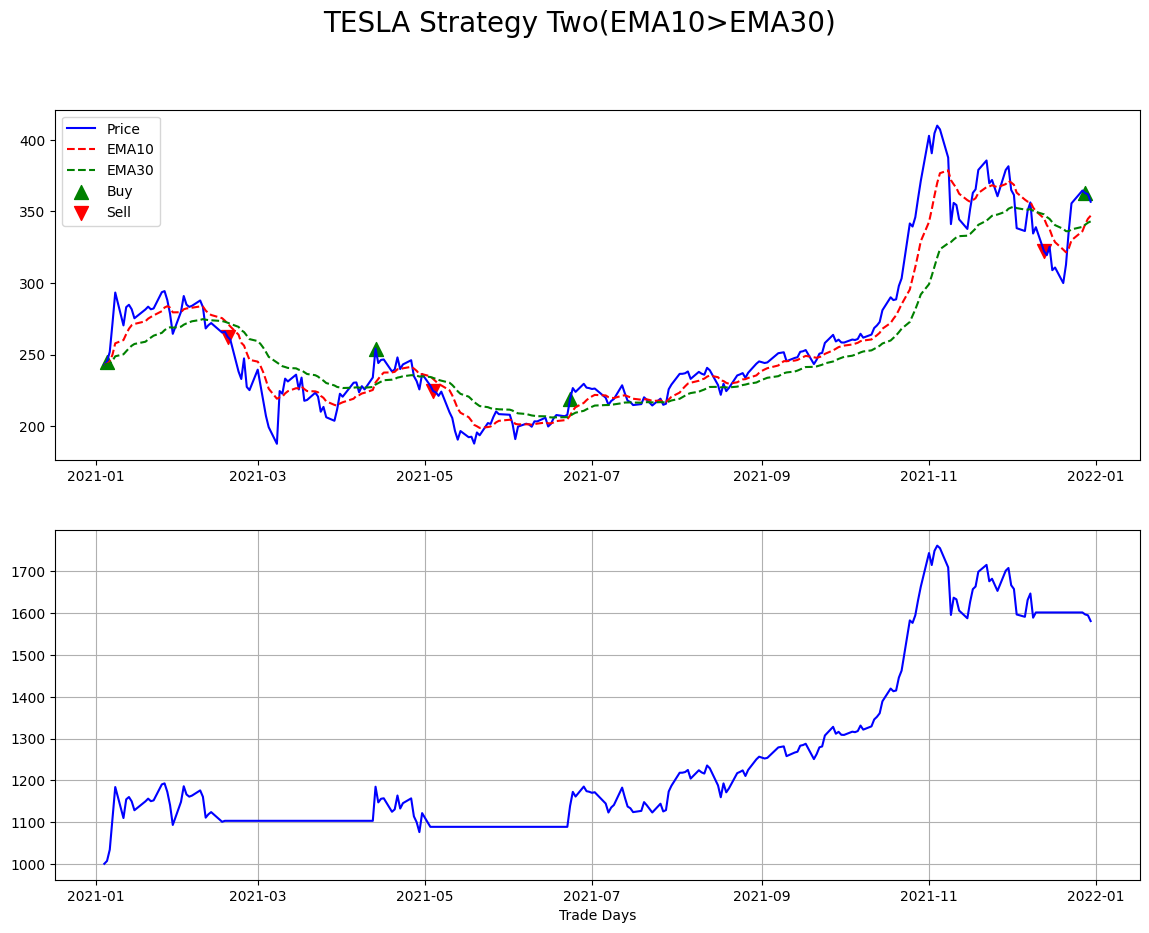

In [57]:
f,axarr = plt.subplots(2,sharex=False,figsize=(14,10))
f.suptitle('TESLA Strategy Two(EMA10>EMA30)', fontsize=20)
axarr[0].plot(df["price"],label="Price",color='blue')
axarr[0].plot(df["EMA10"],label="EMA10",color='red',linestyle='--')
axarr[0].plot(df["EMA30"],label="EMA30",color='green',linestyle='--')
axarr[0].scatter(df.loc[df["buy_s2_ind"] == 1].index,
                df.loc[df["buy_s2_ind"] == 1,"price"].values, color='green', marker='^', s=100, label="Buy")
axarr[0].scatter(df.loc[df["sell_s2_ind"] == 1].index,
                df.loc[df["sell_s2_ind"] == 1,"price"].values, color='red', marker='v', s=100, label="Sell")
            
axarr[0].legend(loc='best')
axarr[1].plot(df["value_s2"],label="Algorithmic Gain",color='blue')
plt.grid(True)
plt.xlabel('Trade Days')
plt.show()

<b>3) MACD > MACDS (s3)

In [58]:
df["MACD"] = ta.trend.macd(df["price"],fillna=True,window_fast=12,window_slow=26)
df["MACD_signal"] = ta.trend.macd_signal(df["price"],
                    window_fast=12,window_slow=26,window_sign=9, 
                    fillna=True)

In [59]:
df["buy_s3"] = np.where((df["MACD"] > df["MACD_signal"]), 1, 0)
df["sell_s3"] = np.where((df["MACD"] < df["MACD_signal"]), 1, 0)
df["buy_s3_ind"] = np.where((df["buy_s3"] > df["buy_s3"].shift(1)),1, 0)
df["sell_s3_ind"] = np.where((df["sell_s3"] > df["sell_s3"].shift(1)),1, 0)

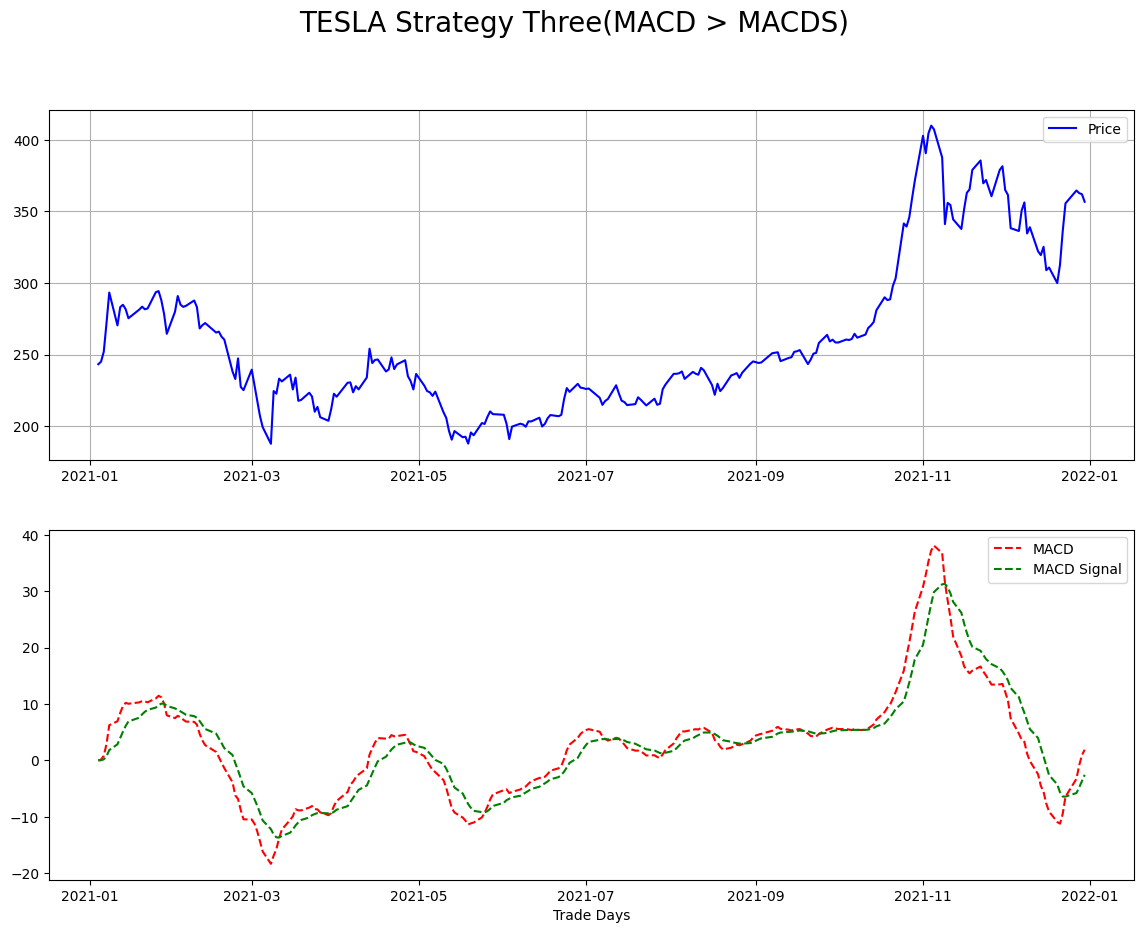

In [65]:
f,axarr = plt.subplots(2,sharex=False,figsize=(14,10))
f.suptitle('TESLA Strategy Three(MACD > MACDS)', fontsize=20)
axarr[0].plot(df["price"],label="Price",color='blue')
axarr[0].legend(loc='best')
axarr[0].grid(True)
axarr[1].plot(df["MACD"],label="MACD",color='red',linestyle='--')
axarr[1].plot(df["MACD_signal"],label="MACD Signal",color='green',linestyle='--')


axarr[1].legend(loc='best')
plt.xlabel('Trade Days')
plt.show()



<b>Trading Gain according to Strategy Three

In [66]:
df["value_s3"] = 1000*(1+(np.where(df["buy_s3"]==1,
                                0.95*df["return_pct"],0)).cumsum())

# Back-Test Report (s3)

In [67]:
print("************* Descriptive Statistics *************")
print("Period",len(df),"days")
print("Highest Daily Loss ",100*round(df["return_pct"].min(),2),"%")
print("Highest Daily Return ",100*round(df["return_pct"].max(),2),"%")
print("Standard Deviation of Return ",100*round(df["return_pct"].std(),2),"%")
print("Total Potential Return ",100*(round(sum(np.where((df["return_pct"]>0),df["return_pct"],0)),2)),"%")
print("Total Potential Loss ",100*(round(sum(np.where((df["return_pct"]<0),df["return_pct"],0)),2)),"%")
print("Net Return ",100*df["return_pct"].sum().round(2),"%")

print("************* MODEL PERFORMANCE *************")

print("Return Captured by the Model ",100*sum(np.where((df["buy_s3"]==1),df["return_pct"],0)).round(2),"%")
print("Loss Maintained by the Model ",100*sum(np.where((df["sell_s3"]==1),df["return_pct"],0)).round(2),"%")
print("**************************************************")


************* Descriptive Statistics *************
Period 251 days
Highest Daily Loss  -12.0 %
Highest Daily Return  20.0 %
Standard Deviation of Return  3.0 %
Total Potential Return  336.0 %
Total Potential Loss  -283.0 %
Net Return  53.0 %
************* MODEL PERFORMANCE *************
Return Captured by the Model  72.0 %
Loss Maintained by the Model  -19.0 %
**************************************************


In [68]:
print("************* REPORT *************")
print("The end-of-period price of the stock, which was $",df["price"][0].round(2),
    "at the beginning of the period, became $",df["price"][-1].round(2),"with %",
    (100*(df["price"][-1]-df["price"][0])/df["price"][0]).round(2),"change","The model captured %",
    100*(sum(np.where((df["buy_s3"]==1),df["return_pct"],0))/sum(np.where((df["return_pct"]>0),
                                                                    df["return_pct"],0))).round(2),
    "of the total positive return.The investment of $1000 at the beginning of the period became $",
    df["value_s3"][-1].round(2),
    "on the first",len(df),"days.")

************* REPORT *************
The end-of-period price of the stock, which was $ 243.26 at the beginning of the period, became $ 356.78 with % 46.67 change The model captured % 21.0 of the total positive return.The investment of $1000 at the beginning of the period became $ 1683.92 on the first 251 days.


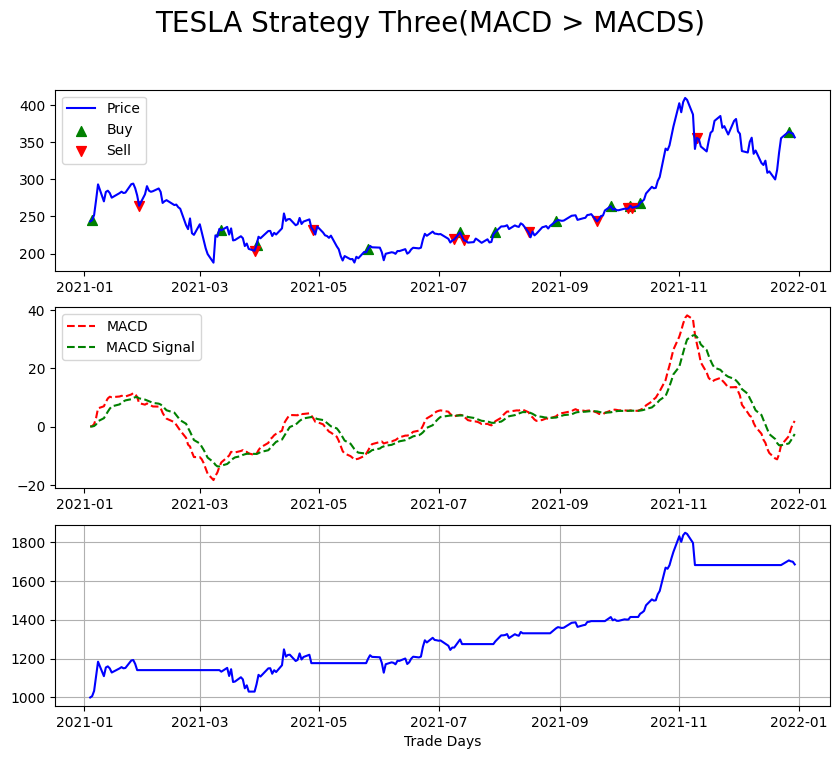

In [83]:
f,axarr = plt.subplots(3,sharex=False,figsize=(10,8))
f.suptitle('TESLA Strategy Three(MACD > MACDS)', fontsize=20)
axarr[0].plot(df["price"],label="Price",color='blue')
axarr[0].scatter(df.loc[df["buy_s3_ind"] == 1].index,
                df.loc[df["buy_s3_ind"] == 1,"price"].values, color='green', marker='^', s=50, label="Buy")
axarr[0].scatter(df.loc[df["sell_s3_ind"] == 1].index,
                df.loc[df["sell_s3_ind"] == 1,"price"].values, color='red', marker='v', s=50, label="Sell")
axarr[0].legend(loc='best')
axarr[1].plot(df["MACD"],label="MACD",color='red',linestyle='--')
axarr[1].plot(df["MACD_signal"],label="MACD Signal",color='green',linestyle='--')

axarr[1].legend(loc='best')
axarr[2].plot(df["value_s3"],label="Algorithmic Gain",color='blue')
plt.grid(True)
plt.xlabel('Trade Days')
plt.show()

<b>Back-Testing is actually a method that we will use in choosing the current strategy. It is natural for price movements to deviate from the direction the strategy is pointing. Since the calculated indicators are created from the movements of the stock, they are very dependent on the price formation. There are many factors that affect the price. Although it recommends the Back-Test Price>EMA10 strategy for 2021, it may not perform the same for 2022 or the first days of 2023. The only strategy can be misleading.<b>

<b>So how can there be a solution to this situation?<b>
<b>Answer: Regression Toward The Mean<b>
- <b>Let's say we create a stronger signal by combining the buy and sell signals pointed out by the three indicators. Buy when two of the three indicators give a buy signal, and sell when it gives a sell signal.<b>





In [84]:
df["BUY"] = np.where((df["buy_s1"]+df["buy_s2"]+df["buy_s3"])>=2,1,0)
df["SELL"] = np.where((df["sell_s1"]+df["sell_s2"]+df["sell_s3"])>=2,1,0)
df["BUY_ind"] = np.where((df["BUY"] > df["BUY"].shift(1)),1, 0)
df["SELL_ind"] = np.where((df["SELL"] > df["SELL"].shift(1)),1, 0)

In [85]:
df["VALUE"] = 1000*(1+(np.where(df["BUY"]==1,
                                0.95*df["return_pct"],0)).cumsum())

In [87]:
print("************* Descriptive Statistics *************")
print("Period",len(df),"days")
print("Highest Daily Loss ",100*round(df["return_pct"].min(),2),"%")
print("Highest Daily Return ",100*round(df["return_pct"].max(),2),"%")
print("Standard Deviation of Return ",100*round(df["return_pct"].std(),2),"%")
print("Total Potential Return ",100*(round(sum(np.where((df["return_pct"]>0),df["return_pct"],0)),2)),"%")
print("Total Potential Loss ",100*(round(sum(np.where((df["return_pct"]<0),df["return_pct"],0)),2)),"%")
print("Net Return ",100*df["return_pct"].sum().round(2),"%")

print("************* MODEL PERFORMANCE *************")

print("Return Captured by the Model ",100*sum(np.where((df["BUY"]==1),df["return_pct"],0)).round(2),"%")
print("Loss Maintained by the Model ",100*sum(np.where((df["SELL"]==1),df["return_pct"],0)).round(2),"%")
print("**************************************************")

print("************* REPORT *************")
print("The end-of-period price of the stock, which was $",df["price"][0].round(2),
    "at the beginning of the period, became $",df["price"][-1].round(2),"with %",
    (100*(df["price"][-1]-df["price"][0])/df["price"][0]).round(2),"change","The model captured %",
    100*(sum(np.where((df["BUY"]==1),df["return_pct"],0))/sum(np.where((df["return_pct"]>0),
                                                                    df["return_pct"],0))).round(2),
    "of the total positive return.The investment of $1000 at the beginning of the period became $",
    df["VALUE"][-1].round(2),
    "on the first",len(df),"days.")


************* Descriptive Statistics *************
Period 251 days
Highest Daily Loss  -12.0 %
Highest Daily Return  20.0 %
Standard Deviation of Return  3.0 %
Total Potential Return  336.0 %
Total Potential Loss  -283.0 %
Net Return  53.0 %
************* MODEL PERFORMANCE *************
Return Captured by the Model  135.0 %
Loss Maintained by the Model  -82.0 %
**************************************************
************* REPORT *************
The end-of-period price of the stock, which was $ 243.26 at the beginning of the period, became $ 356.78 with % 46.67 change The model captured % 40.0 of the total positive return.The investment of $1000 at the beginning of the period became $ 2283.04 on the first 251 days.


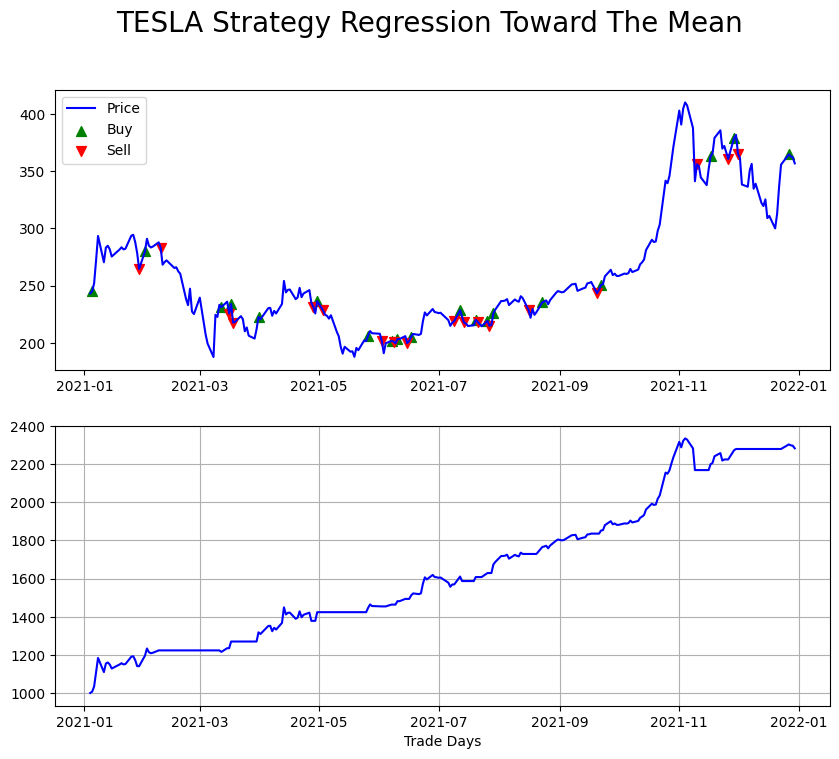

In [88]:
f,axarr = plt.subplots(2,sharex=False,figsize=(10,8))
f.suptitle('TESLA Strategy Regression Toward The Mean', fontsize=20)
axarr[0].plot(df["price"],label="Price",color='blue')
axarr[0].scatter(df.loc[df["BUY_ind"] == 1].index,
                df.loc[df["BUY_ind"] == 1,"price"].values, color='green', marker='^', s=50, label="Buy")

axarr[0].scatter(df.loc[df["SELL_ind"] == 1].index,
                df.loc[df["SELL_ind"] == 1,"price"].values, color='red', marker='v', s=50, label="Sell")
axarr[0].legend(loc='best')
axarr[1].plot(df["VALUE"],label="Algorithmic Gain",color='blue')
plt.grid(True)
plt.xlabel('Trade Days')
plt.show()